In [2]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [3]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [6]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        uniqueModelsToKeep.append(uniqueModels[i])
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [7]:
uniqueModels = getAllUniqueModels()[:7]

***ORIGINAL MODELS***
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 25)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 150)
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 50)
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 50)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 100)
((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)
((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 50)
((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 150)
((5, ('GLD', 36, None, 11, 1), 10, 'XLV'), 5, 300)
((5, ('GLD', 36, None, 11, 1), 10, 'XLV'), 5, 150)
((10, ('KBE', 29, 4, None, 3), 15, 'EEM'), 10, 100)
((2

In [5]:
# uniqueModels = getUniqueModelsForTicker("KRE")

***ORIGINAL MODELS***
((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)
***UNIQUE MODELS***
((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)
25TH PERCENTILE SHARPE -0.6337067875941056
ACTIVITY 0.8881118881118881
ALPHA 0.007988175323716528
ANNUALIZED RETURN -0.011486281434638368
BETA 0.0743272730028087
FACTOR SHARPE 0.5893244467631594
MIN ROLLING SHARPE -1.3928904549409589
OOS_ACTIVITY 0.8809523809523809
OOS_ALPHA 0.09336759044226908
OOS_ANNUALIZED RETURN 0.0924040888470603
OOS_BETA 0.007300853474550487
OOS_FACTOR SHARPE 1.5828331654699737
OOS_RAW BETA 0.11234528721040882
OOS_RELATIVE SHARPE -0.21072972318748795
OOS_RELATIVE SHARPE SLIPPAGE -0.6098572118915898
OOS_SHARPE 1.2492831706585108
OOS_SHARPE DIFFERENCE -0.33354999481146286
OOS_SHARPE DIFFERENCE SLIPPAGE -0.9653022211830575
OOS_SHARPE SLIPPAGE DECAY -0.6317522263715947
OOS_STABILITY 0.7319827336651228
OOS_TOTAL DAYS SEEN 252
OOS_TREYNOR -35.03359140763217
RAW BETA 0.04255704328814437
RELATIVE SHARPE -1.0663703126798745
RELATIVE SHA

In [8]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    aggregateSlippageReturns = None
    cleanedModels = []
    for mod in allModels:
        
        try:
            algoReturn, algoPredictions, algoSlippageAdjustedReturn = dataAck.getModelData(mod)
            print(mod.describe())
            algoReturn.columns = [str(mod.describe())]
            algoPredictions.columns = [str(mod.describe())]
            algoSlippageAdjustedReturn.columns =  [str(mod.describe())]
            if aggregateReturns is None:
                aggregateReturns = algoReturn
                aggregatePredictions = algoPredictions
                aggregateSlippageReturns = algoSlippageAdjustedReturn
            else:
                aggregateReturns = aggregateReturns.join(algoReturn)
                aggregatePredictions = aggregatePredictions.join(algoPredictions)
                aggregateSlippageReturns = aggregateSlippageReturns.join(algoSlippageAdjustedReturn)
            cleanedModels.append(mod)
        except:
            print("SKIPPING", mod.describe())
    return aggregateReturns, aggregatePredictions, aggregateSlippageReturns, cleanedModels

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
            
    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions, modelSlippageReturns, cleanedModels = generateAllReturnsFromCache(uniqueModels)
    
    return cleanedModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [17]:
factorToTrade = "SPY"
uniqueModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)
IYR
VTV
RSP
LQD
VGT
SPY
XLV
ATTEMPTING PULL b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad
((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)
ATTEMPTING PULL 1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
ATTEMPTING PULL 2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
ATTEMPTING PULL 2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
ATTEMPTING PULL 6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 1

In [18]:
display(joinedData)

,Adj_Close_IYR,Adj_Close_VTV,Adj_Close_VGT,Adj_Close_XLV,Adj_Close_RSP,Adj_Close_LQD,Adj_Close_SPY
Date,,,,,,,
1993-01-29,NaN,NaN,NaN,NaN,NaN,NaN,27.742226
1993-02-01,NaN,NaN,NaN,NaN,NaN,NaN,27.939539
1993-02-02,NaN,NaN,NaN,NaN,NaN,NaN,27.998702
1993-02-03,NaN,NaN,NaN,NaN,NaN,NaN,28.294703
1993-02-04,NaN,NaN,NaN,NaN,NaN,NaN,28.413091
1993-02-05,NaN,NaN,NaN,NaN,NaN,NaN,28.393328
1993-02-08,NaN,NaN,NaN,NaN,NaN,NaN,28.393328
1993-02-09,NaN,NaN,NaN,NaN,NaN,NaN,28.196015
1993-02-10,NaN,NaN,NaN,NaN,NaN,NaN,28.235477


TICKER SHARPE 0.47470554497 SHARPE 0.871064614758 SLIPPAGE SHARPE 0.731281667465


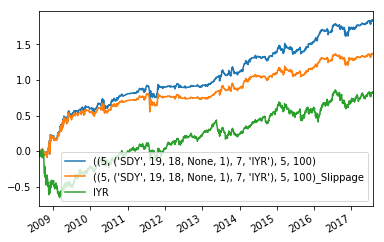

TICKER SHARPE 0.496407017052 SHARPE 0.923274951294 SLIPPAGE SHARPE 0.818193816883


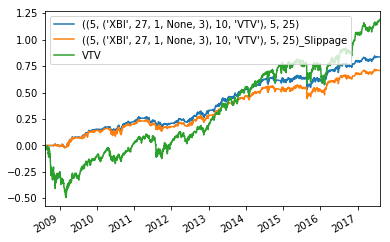

TICKER SHARPE 0.54405501268 SHARPE 0.89358803944 SLIPPAGE SHARPE 0.817737930784


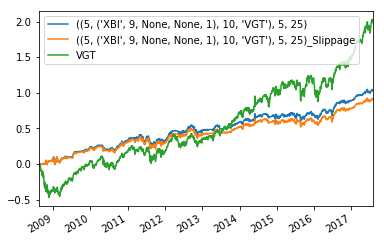

TICKER SHARPE 0.502106619253 SHARPE 0.728601718665 SLIPPAGE SHARPE 0.530182942312


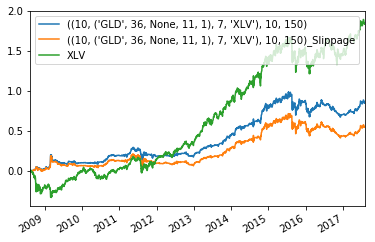

TICKER SHARPE 0.621650559285 SHARPE 0.701620770301 SLIPPAGE SHARPE 0.524916143387


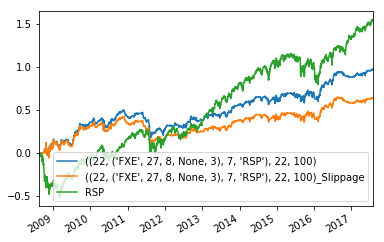

TICKER SHARPE 0.54405501268 SHARPE 0.84557836968 SLIPPAGE SHARPE 0.781577983478


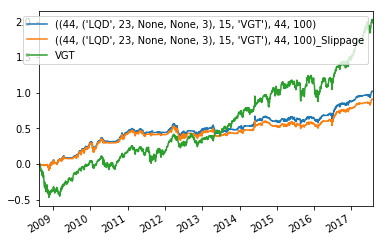

TICKER SHARPE 0.79010737818 SHARPE 1.14974983989 SLIPPAGE SHARPE 0.664468965647


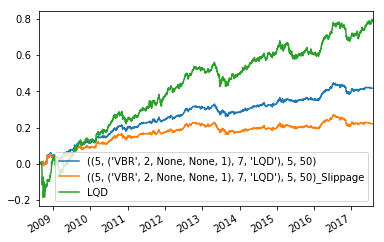

In [19]:
##PERFORM SANITY CHECK
import empyrical
import portfolioGeneration
import matplotlib.pyplot as plt
for i in range(len(modelReturns.columns)):
    item = modelReturns.columns[i]
    slipper = modelSlippageReturns[[modelReturns.columns[i]]]
    slipper.columns = [modelReturns.columns[i] + "_Slippage"]
    tickerReturn = dataAck.getDailyFactorReturn(uniqueModels[i].inputSeries.targetTicker, joinedData)
    tickerReturn.columns = [uniqueModels[i].inputSeries.targetTicker]
    empyrical.cum_returns(modelReturns[[modelReturns.columns[i]]].join(slipper).join(tickerReturn)).plot()
    print("TICKER SHARPE", empyrical.sharpe_ratio(tickerReturn), "SHARPE", empyrical.sharpe_ratio(modelReturns[[modelReturns.columns[i]]]), "SLIPPAGE SHARPE", empyrical.sharpe_ratio(modelSlippageReturns[[modelReturns.columns[i]]])) 
    plt.show()

,"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)","((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)","((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)","((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)","((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)","((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)","((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)",Factor Return
"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)",1.000000,0.276218,0.325315,0.101950,0.447120,0.373275,0.132722,0.396789
"((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)",0.276218,1.000000,0.621993,0.499887,0.466094,0.407367,-0.070088,0.664044
"((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)",0.325315,0.621993,1.000000,0.363818,0.575657,0.557823,-0.020436,0.632500
"((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)",0.101950,0.499887,0.363818,1.000000,0.307469,0.301326,-0.087772,0.398004
"((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)",0.447120,0.466094,0.575657,0.307469,1.000000,0.369600,-0.010083,0.508918
"((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)",0.373275,0.407367,0.557823,0.301326,0.369600,1.000000,-0.025787,0.551974
"((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)",0.132722,-0.070088,-0.020436,-0.087772,-0.010083,-0.025787,1.000000,-0.061144
Factor Return,0.396789,0.664044,0.632500,0.398004,0.508918,0.551974,-0.061144,1.000000


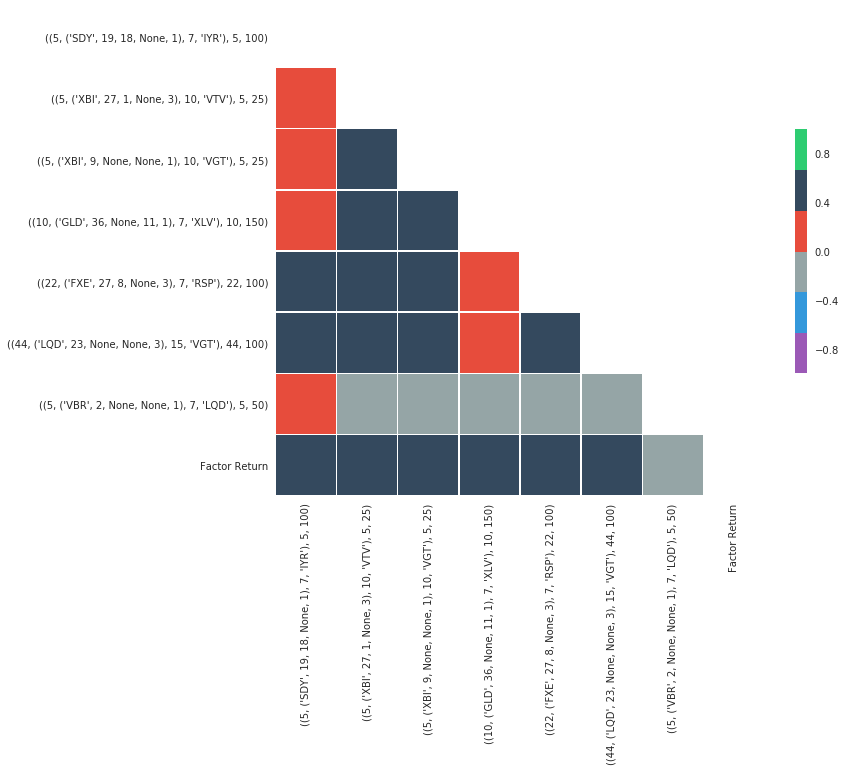

,"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)","((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)","((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)","((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)","((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)","((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)","((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)",Factor Return
"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)",0.000084,1.254128e-05,1.779278e-05,0.000006,3.056054e-05,2.151461e-05,2.603525e-06,0.000044
"((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)",0.000013,2.460330e-05,1.843435e-05,0.000016,1.726287e-05,1.272311e-05,-7.450132e-07,0.000040
"((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)",0.000018,1.843435e-05,3.570183e-05,0.000014,2.568336e-05,2.098710e-05,-2.616721e-07,0.000046
"((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)",0.000006,1.598343e-05,1.401298e-05,0.000042,1.479945e-05,1.223062e-05,-1.212504e-06,0.000031
"((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)",0.000031,1.726287e-05,2.568336e-05,0.000015,5.575519e-05,1.737742e-05,-1.613422e-07,0.000046
"((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)",0.000022,1.272311e-05,2.098710e-05,0.000012,1.737742e-05,3.964808e-05,-3.479624e-07,0.000042
"((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)",0.000003,-7.450132e-07,-2.616721e-07,-0.000001,-1.613422e-07,-3.479624e-07,4.592482e-06,-0.000002
Factor Return,0.000044,3.977561e-05,4.563824e-05,0.000031,4.588957e-05,4.197137e-05,-1.582357e-06,0.000146


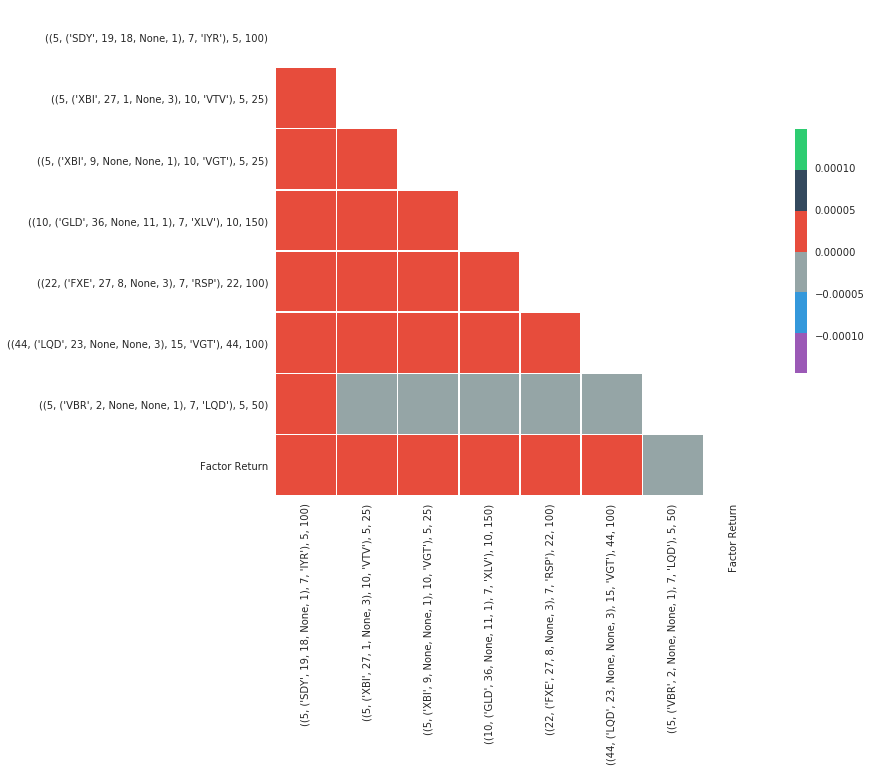

In [20]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [22]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

[]
((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)
NEED TO STORE 2192
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
NEED TO STORE 2192
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
NEED TO STORE 2192
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
NEED TO STORE 2192
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)
NEED TO STORE 2192
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
NEED TO STORE 2192
((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)
NEED TO STORE 2192


In [23]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="TESTING SCALED", benchmark=factorToTrade, portfolioType="HRP")
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
display(portfolioInfo)

PORTFOLIO HASH: ba3c0be71164f3efa53f9c2ac5733b715914bfadfdb170d2ba579433
1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075
2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa
2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a
3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22
6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f
b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad
fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006


<Entity('walkforward_portfolio_info', 'ba3c0be71164f3efa53f9c2ac5733b715914bfadfdb170d2ba579433') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'description': 'TESTING SCALED', 'portfolioType': 'HRP', 'benchmark': 'SPY'}>

In [24]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa',
 '2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a',
 '3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22',
 '6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f',
 '1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075',
 'b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad',
 'fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006']

In [25]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [26]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22,2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa,fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006,b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad,1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075,6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f,2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a
2008-10-16,0.000208,0.000633,-0.001329,0.000974,0.000018,0.006937,-0.002724
2008-10-17,-0.002567,-0.008667,0.008575,-0.000750,0.000000,-0.034242,0.010682
2008-10-20,0.004136,0.016260,0.003424,0.002692,0.000047,0.023222,-0.004493
2008-10-21,0.002843,0.012907,-0.004665,0.008041,0.000119,0.033991,-0.018252
2008-10-22,0.000497,0.002698,0.003323,0.001219,-0.000027,0.003320,-0.000103
2008-10-23,0.001476,0.010276,0.002386,0.008010,0.000270,0.022553,-0.000413
2008-10-24,0.000972,0.009626,-0.004474,0.009797,0.000250,0.028934,-0.015448
2008-10-27,-0.002201,-0.038545,-0.005216,-0.035765,-0.001051,-0.076390,0.028333
2008-10-28,0.000006,0.000845,0.014241,0.011213,0.000202,0.002584,-0.012752
2008-10-29,0.000370,-0.007871,-0.006426,-0.016731,-0.000461,-0.021717,0.005829


In [27]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22,2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa,fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006,b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad,1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075,6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f,2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a
2008-10-16,0.000208,0.000633,-0.001329,0.000974,0.000018,0.006937,-0.002724
2008-10-17,-0.002567,-0.008667,0.008575,-0.000750,0.000000,-0.034242,0.010682
2008-10-20,0.004136,0.016260,0.003424,0.002692,0.000047,0.023222,-0.004493
2008-10-21,0.002843,0.012907,-0.004665,0.008041,0.000119,0.033991,-0.018252
2008-10-22,0.000497,0.002698,0.003323,0.001219,-0.000027,0.003320,-0.000103
2008-10-23,0.001476,0.010276,0.002386,0.008010,0.000270,0.022553,-0.000413
2008-10-24,0.000972,0.009626,-0.004474,0.009797,0.000250,0.028934,-0.015448
2008-10-27,-0.002201,-0.038545,-0.005216,-0.035765,-0.001051,-0.076390,0.028333
2008-10-28,0.000006,0.000845,0.014241,0.011213,0.000202,0.002584,-0.012752
2008-10-29,0.000370,-0.007871,-0.006426,-0.016731,-0.000461,-0.021717,0.005829


,3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22,2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa,fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006,b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad,1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075,6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f,2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a
2008-10-16,-0.083923,-0.255859,0.156250,-0.093750,-0.001953,-0.437500,0.250000
2008-10-17,-0.082153,-0.277344,0.281250,-0.078125,0.000000,-0.468750,0.281250
2008-10-20,-0.078003,-0.306641,0.343750,-0.078125,-0.001953,-0.515625,0.375000
2008-10-21,-0.071411,-0.324219,0.406250,-0.109375,-0.001953,-0.531250,0.421875
2008-10-22,-0.062622,-0.339844,0.531250,-0.078125,-0.001953,-0.531250,0.390625
2008-10-23,-0.051331,-0.357422,0.593750,-0.125000,-0.007812,-0.562500,0.359375
2008-10-24,-0.037476,-0.371094,0.687500,-0.187500,-0.007812,-0.593750,0.312500
2008-10-27,-0.021301,-0.373047,0.781250,-0.218750,-0.009766,-0.640625,0.250000
2008-10-28,-0.002808,-0.380859,0.843750,-0.281250,-0.009766,-0.671875,0.203125
2008-10-29,0.017822,-0.378906,0.875000,-0.343750,-0.017578,-0.656250,0.125000


In [28]:
if portfolioInfo["portfolioType"] == "HRP":
    print("HRP")
    ##HRP ALLOCATION
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
            126, startIndex=None, maxWindowSize=False)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW":
    print("EW")
    ##EW ALLOCATION
    ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                     None)
    display(ewReturns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW By Ticker":
    print("EW By Ticker")
    weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
    

HRP
COMPUTED HISTORICAL WEIGHTS


,1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075,2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa,2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a,3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22,6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f,b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad,fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006
2009-04-21,0.219679,0.038581,0.112339,0.033002,0.014256,0.005949,0.576193
2009-04-22,0.219350,0.038753,0.112586,0.033157,0.014320,0.005968,0.575867
2009-04-23,0.219072,0.038755,0.112581,0.033156,0.014313,0.005967,0.576157
2009-04-24,0.218004,0.038746,0.112831,0.033240,0.014303,0.005982,0.576894
2009-04-28,0.217298,0.038815,0.113068,0.033313,0.014306,0.005994,0.577206
2009-04-29,0.215417,0.038951,0.113871,0.033579,0.014379,0.006037,0.577766
2009-04-30,0.215398,0.038966,0.113911,0.033595,0.014386,0.006040,0.577705
2009-05-01,0.215354,0.038973,0.113958,0.033610,0.014392,0.006042,0.577671
2009-05-04,0.210193,0.039018,0.114450,0.033801,0.014452,0.006051,0.582035
2009-05-05,0.210105,0.039004,0.114280,0.033808,0.014454,0.006052,0.582297


In [29]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"],
    "portfolioType":portfolioInfo["portfolioType"],
    "startedTrading":portfolioInfo["startedTrading"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData, portfolioInfo["startedTrading"])
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData, params.AVAILABLE_MODE)

{'key': 'ba3c0be71164f3efa53f9c2ac5733b715914bfadfdb170d2ba579433', 'description': 'TESTING SCALED', 'benchmark': 'SPY', 'portfolioType': 'HRP', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)
((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)


# STORE ALL TICKERS AS OWN MODELS

In [5]:
import importlib
importlib.reload(portfolio)
importlib.reload(portfolioGeneration)

<module 'portfolioGeneration' from '/home/prohb125/walkforwardTrader/portfolioGeneration.py'>

In [3]:
allModels = portfolio.getModels(returnEntireObject=False)
for model in allModels[:3]:
    factorToTrade = model.inputSeries.targetTicker
    portfolioHash = portfolioGeneration.getPortfolioHash([model],\
            description="Model Alone", benchmark=factorToTrade, portfolioType="EW")
    
    if portfolio.getPortfolioByKey(portfolioHash) is not None:
        print("ALREADY SAVED", model.describe())
        continue
    
    portfolioHash = portfolioGeneration.storePortfolio([model],\
            description="Model Alone", benchmark=factorToTrade, portfolioType="EW")
    
    ##TEST TO SEE IF ALREADY EXISTS
    
    uniqueModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturnsWithFactor, joinedData =\
        computeReturnsForUniqueModelsCache([model], factorToTrade)
    portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)
    
    
    portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
    display(portfolioInfo)
    modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
    allModels = portfolio.getModelsByKey(modelHashes)
    aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
    
    cleanedAggregateReturns = aggregateReturns.dropna()
    cleanedAggregatePredictions = aggregatePredictions.dropna()
    if portfolioInfo["portfolioType"] == "HRP":
        print("HRP")
        ##HRP ALLOCATION
        hrpReturns, historicalWeights = portfolioGeneration.\
                produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                22, startIndex=None, maxWindowSize=True)
        print("COMPUTED HISTORICAL WEIGHTS")
        display(historicalWeights)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    elif portfolioInfo["portfolioType"] == "EW":
        print("EW")
        ##EW ALLOCATION
        ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                         None)
        display(ewReturns)
        historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    elif portfolioInfo["portfolioType"] == "EW By Ticker":
        print("EW By Ticker")
        weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
        historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    
    
    portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
    portfolioInfo = {
        "key":portfolioInfo.key.name,
        "description":portfolioInfo["description"],
        "benchmark":portfolioInfo["benchmark"],
        "portfolioType":portfolioInfo["portfolioType"],
        "startedTrading":portfolioInfo["startedTrading"]
    }
    print(portfolioInfo)
    portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData, portfolioInfo["startedTrading"])
    portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData, params.AVAILABLE_MODE)

PORTFOLIO HASH: f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac
016b0ddc5c91859908d1a714c111ea0b31773a12d78eab69a2f68d0e
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
IYR
ATTEMPTING PULL 016b0ddc5c91859908d1a714c111ea0b31773a12d78eab69a2f68d0e
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
NEED TO STORE 2252


<Entity('walkforward_portfolio_info', 'f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'description': 'Model Alone', 'portfolioType': 'EW', 'benchmark': 'IYR'}>

EW


,0
2008-08-11,-1.352006e-06
2008-08-12,-1.968072e-06
2008-08-13,3.038465e-06
2008-08-14,-4.981445e-07
2008-08-15,-7.634072e-06
2008-08-18,-8.828504e-06
2008-08-19,1.287826e-06
2008-08-20,-9.136455e-06
2008-08-21,1.813030e-05
2008-08-22,-2.431116e-05


{'key': 'f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac', 'description': 'Model Alone', 'benchmark': 'IYR', 'portfolioType': 'EW', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
PORTFOLIO HASH: 97b325eafc41e99f810e47cf44540480184559c7120c0f80a48c433c
050488c6e0df18e029696590d4ba146069d4b8f11886e859441c63a4
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
VTV
ATTEMPTING PULL 050488c6e0df18e029696590d4ba146069d4b8f11886e859441c63a4
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
NEED TO STORE 2208


<Entity('walkforward_portfolio_info', '97b325eafc41e99f810e47cf44540480184559c7120c0f80a48c433c') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'benchmark': 'VTV', 'portfolioType': 'EW', 'description': 'Model Alone'}>

EW


,0
2008-10-16,5.732584e-07
2008-10-17,-6.127344e-06
2008-10-20,4.424482e-06
2008-10-21,1.488095e-05
2008-10-22,-3.395755e-06
2008-10-23,1.055338e-05
2008-10-24,1.170834e-05
2008-10-27,-5.913131e-05
2008-10-28,1.263842e-05
2008-10-29,-1.920362e-05


{'key': '97b325eafc41e99f810e47cf44540480184559c7120c0f80a48c433c', 'description': 'Model Alone', 'benchmark': 'VTV', 'portfolioType': 'EW', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
PORTFOLIO HASH: c5fce4f49b7d36f81c0b4c75398e99390fa0b8bbd27f4365769e86a3
10184f6ec13c258148064a8c007add65b837f4904e939b71e276b749
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
VGT
ATTEMPTING PULL 10184f6ec13c258148064a8c007add65b837f4904e939b71e276b749
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
NEED TO STORE 2228


<Entity('walkforward_portfolio_info', 'c5fce4f49b7d36f81c0b4c75398e99390fa0b8bbd27f4365769e86a3') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'benchmark': 'VGT', 'description': 'Model Alone', 'portfolioType': 'EW'}>

EW


,0
2008-09-17,-2.319197e-06
2008-09-18,0.000000e+00
2008-09-19,-2.202156e-06
2008-09-22,4.785284e-07
2008-09-23,-2.250995e-07
2008-09-24,-2.159103e-06
2008-09-25,-7.955919e-07
2008-09-26,2.438499e-05
2008-09-29,-1.628945e-05
2008-09-30,1.141555e-05


{'key': 'c5fce4f49b7d36f81c0b4c75398e99390fa0b8bbd27f4365769e86a3', 'description': 'Model Alone', 'benchmark': 'VGT', 'portfolioType': 'EW', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
